In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
     |████████████████████████████████| 1.2 MB 29.3 MB/s 
     |████████████████████████████████| 186 kB 22.2 MB/s 
     |████████████████████████████████| 56 kB 3.9 MB/s 
     |████████████████████████████████| 51 kB 337 kB/s 
Mounted at /content/gdrive


In [5]:
import fastai.vision.all as fv
import torch
import torch.nn as nn
from pathlib import Path
from fastbook import *

In [ ]:
# def load_data(folder, img_size, batch_size):
#     tfms = fv.aug_transforms(flip_vert=True, 
#                              max_rotate=360, 
#                              max_lighting=0.25, 
#                              max_zoom=1.2, 
#                              max_warp=0.2)
    
#     data = fv.DataBlock(blocks    = (fv.ImageBlock, fv.CategoryBlock),
#                         get_items = fv.get_image_files,
#                         get_y     = fv.parent_label,
#                         splitter  = fv.GrandparentSplitter(),
#                         item_tfms = fv.Resize(img_size),
#                         batch_tfms= tfms,
#                      )
#     return data.dataloaders(folder, bs=batch_size)

In [9]:
items = get_image_files(untar_data(URLs.MNIST))

In [10]:
items

(#70000) [Path('/root/.fastai/data/mnist_png/testing/1/8396.png'),Path('/root/.fastai/data/mnist_png/testing/1/9898.png'),Path('/root/.fastai/data/mnist_png/testing/1/9348.png'),Path('/root/.fastai/data/mnist_png/testing/1/1180.png'),Path('/root/.fastai/data/mnist_png/testing/1/7468.png'),Path('/root/.fastai/data/mnist_png/testing/1/4853.png'),Path('/root/.fastai/data/mnist_png/testing/1/918.png'),Path('/root/.fastai/data/mnist_png/testing/1/1083.png'),Path('/root/.fastai/data/mnist_png/testing/1/4249.png'),Path('/root/.fastai/data/mnist_png/testing/1/6938.png')...]

In [11]:
splits = GrandparentSplitter(train_name='training', valid_name='testing')
splits = splits(items)

In [21]:
splits[0][0]

10000

In [22]:
dsrc = Datasets(items, 
                tfms=[[PILImageBW.create],
                [parent_label, Categorize]],
                splits=splits)

In [41]:
print(len(dsrc))
print(dsrc[-1][1])
dsrc[-1][0]

70000
TensorCategory(4)


In [48]:
tfms = [ToTensor(), RandomCrop(size=28)]
gpu_tfms = [IntToFloatTensor(), Normalize()]

In [57]:
data = dsrc.dataloaders(bs=128, after_item=tfms, after_batch=gpu_tfms)

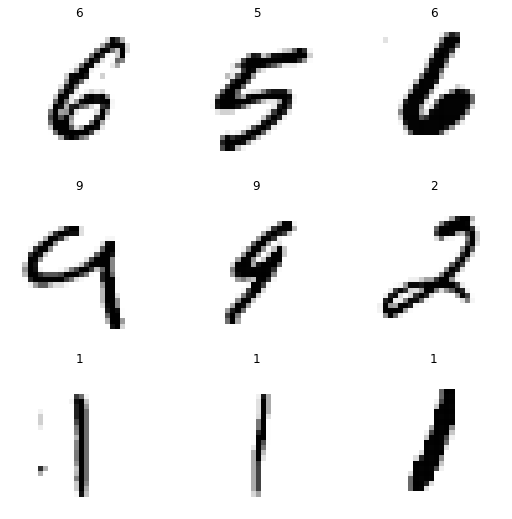

In [58]:
data.show_batch()

In [54]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        #return x.squeeze()
        return x.reshape(x.shape[0],-1)

def num_params(model):
    return sum([prod(p.shape) for p in model.parameters()])

In [ ]:
# data = load_data(flowers, img_size=128, batch_size=128)

In [74]:
# def get_model(trial=None):
#     return nn.Sequential(
#             nn.BatchNorm2d(3),
#             nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#             nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(128),
#             nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(256),
#             nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(512),
#             nn.AdaptiveAvgPool2d(1),
#             Flatten(),
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Linear(256, data.c))

In [110]:

def get_model(trial=None):
  return nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(8),
            nn.Conv2d(8,32, kernel_size=4, stride=2, padding=1),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.Conv2d(128, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64,128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.AdaptiveAvgPool2d(1),
            Flatten(), # and flatten it into a single dimention of predictions
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, data.c)
            
)

In [111]:
learn = fv.Learner(data, get_model(), metrics=fv.accuracy, opt_func=fv.ranger)

SuggestedLRs(valley=0.0014454397605732083)

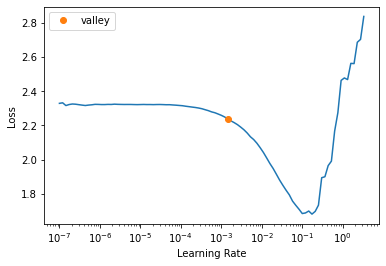

In [112]:
learn.lr_find()

In [113]:
learn.fit_one_cycle(7, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.209435,0.114849,0.972200,01:54
1,0.082115,0.049074,0.983800,01:52
2,0.060879,0.044058,0.985200,01:52
3,0.043486,0.037767,0.986500,01:52
4,0.028822,0.032140,0.988900,01:53
5,0.013947,0.026768,0.991300,01:53
6,0.011716,0.027276,0.990900,01:52


# Usando optuna para encontrar mejores hiperparámetros

Optuna es un programa para optimizar hiperparámetros. Se puede instalar con pip install optuna.

In [ ]:
!pip install optuna

In [116]:
import optuna

Hay que crear un "estudio", y después correrlo con una función objetivo:

In [117]:
study = optuna.create_study(direction='maximize')

[I 2021-09-09 16:15:02,147] A new study created in memory with name: no-name-2eda6013-00b4-4e45-acb4-92afd9428e3a


In [118]:
accuracy_index = learn.recorder.metric_names.index('accuracy')
learn.recorder.log[accuracy_index]

0.9908999800682068

In [119]:
def objective(trial):
    optimizer = trial.suggest_categorical('optimizer',["Ranger", "Adam"])
    opt_func = fv.ranger if optimizer == "Ranger" else fv.Adam
    learn = fv.Learner(data, get_model(trial), metrics=fv.accuracy, opt_func=opt_func)
    learn.fit_one_cycle(trial.suggest_int('epochs',1,10), 
                        trial.suggest_float('lr',1e-5,1e-1,log=True),
                        div = trial.suggest_float('div',0.5,1.5)
                       )
    
    accuracy_index = learn.recorder.metric_names.index('accuracy')
    return learn.recorder.log[accuracy_index]

In [120]:
study.optimize(objective,n_trials=50)

epoch,train_loss,valid_loss,accuracy,time
0,0.093617,0.066134,0.979800,01:51
1,0.060497,0.048030,0.983700,01:51
2,0.042902,0.037147,0.987800,01:50
3,0.021893,0.027209,0.990900,01:50


[I 2021-09-09 16:22:50,448] Trial 0 finished with value: 0.9908999800682068 and parameters: {'optimizer': 'Ranger', 'epochs': 4, 'lr': 0.0032709564282075373, 'div': 0.7775851784303219}. Best is trial 0 with value: 0.9908999800682068.


epoch,train_loss,valid_loss,accuracy,time
0,0.133659,0.083261,0.975200,01:50
1,0.099494,0.087742,0.972800,01:50
2,0.063821,0.050282,0.985400,01:49
3,0.034569,0.030208,0.990300,01:49
4,0.026682,0.024431,0.992600,01:49


[I 2021-09-09 16:32:00,391] Trial 1 finished with value: 0.9926000237464905 and parameters: {'optimizer': 'Adam', 'epochs': 5, 'lr': 0.013007602754429732, 'div': 1.117101589194725}. Best is trial 1 with value: 0.9926000237464905.


epoch,train_loss,valid_loss,accuracy,time
0,0.102078,0.060991,0.980400,01:50
1,0.071095,0.044282,0.985800,01:49
2,0.060297,0.037615,0.988900,01:48
3,0.040492,0.033852,0.990200,01:51
4,0.030856,0.032673,0.989700,01:53
5,0.021851,0.029052,0.990600,01:53
6,0.011676,0.026376,0.991900,01:54
7,0.009991,0.025555,0.991700,01:54


[I 2021-09-09 16:46:56,265] Trial 2 finished with value: 0.9916999936103821 and parameters: {'optimizer': 'Ranger', 'epochs': 8, 'lr': 0.00340300753773356, 'div': 0.5955760654266516}. Best is trial 1 with value: 0.9926000237464905.


epoch,train_loss,valid_loss,accuracy,time
0,0.818859,0.679552,0.936800,01:54
1,0.299405,0.248924,0.970300,01:55
2,0.141501,0.122686,0.977000,01:54
3,0.090735,0.082236,0.980900,01:53
4,0.070782,0.064919,0.983500,01:50
5,0.059448,0.058971,0.984600,01:52


KeyboardInterrupt: ignored

In [121]:
study.best_params

{'div': 1.117101589194725,
 'epochs': 5,
 'lr': 0.013007602754429732,
 'optimizer': 'Adam'}

In [122]:
study.best_value

0.9926000237464905

## El modelo

Probablemente quieras hacer algo con el modelo, como número de capas, etc. Como optuna, a diferencia de otros, es eager, puedes cambiar el número de capas, filtros, etc. etc. mientras va ejecutando todo!

# Una última cosa

A veces uno tiene ideas de cómo debería ser el modelo, o modelos previamente ejecutados. Puedes probarlos así:

In [127]:
study.enqueue_trial(params = {'optimizer':'Adam', 'epochs':5, 'lr':0.01300760, 'div':1.11710})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning:

enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.

/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:857: ExperimentalWarning:

create_trial is experimental (supported from v2.0.0). The interface can change in the future.

/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:857: ExperimentalWarning:

add_trial is experimental (supported from v2.0.0). The interface can change in the future.



In [128]:
t = study.get_trials(deepcopy=False)[-1]

In [129]:
t.set_user_attr('nombre','Pedrito')

In [130]:
study.optimize(objective,n_trials=1)

epoch,train_loss,valid_loss,accuracy,time
0,0.145606,0.110062,0.968200,01:53
1,0.095079,0.073426,0.978000,01:55
2,0.071503,0.063996,0.983200,01:54
3,0.035907,0.031240,0.990900,01:52
4,0.021924,0.027265,0.991600,01:54


[I 2021-09-09 17:10:12,391] Trial 5 finished with value: 0.991599977016449 and parameters: {'optimizer': 'Adam', 'epochs': 5, 'lr': 0.0130076, 'div': 1.1171}. Best is trial 1 with value: 0.9926000237464905.


In [131]:
study.best_params

{'div': 1.117101589194725,
 'epochs': 5,
 'lr': 0.013007602754429732,
 'optimizer': 'Adam'}

In [132]:
study.best_value

0.9926000237464905

In [133]:
study.trials

[FrozenTrial(number=0, values=[0.9908999800682068], datetime_start=datetime.datetime(2021, 9, 9, 16, 15, 25, 874254), datetime_complete=datetime.datetime(2021, 9, 9, 16, 22, 50, 448276), params={'optimizer': 'Ranger', 'epochs': 4, 'lr': 0.0032709564282075373, 'div': 0.7775851784303219}, distributions={'optimizer': CategoricalDistribution(choices=('Ranger', 'Adam')), 'epochs': IntUniformDistribution(high=10, low=1, step=1), 'lr': LogUniformDistribution(high=0.1, low=1e-05), 'div': UniformDistribution(high=1.5, low=0.5)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None),
 FrozenTrial(number=1, values=[0.9926000237464905], datetime_start=datetime.datetime(2021, 9, 9, 16, 22, 50, 455758), datetime_complete=datetime.datetime(2021, 9, 9, 16, 32, 0, 391361), params={'optimizer': 'Adam', 'epochs': 5, 'lr': 0.013007602754429732, 'div': 1.117101589194725}, distributions={'optimizer': CategoricalDistribution(choices=('Ranger', 'Adam')), 'e